### Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.
#### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя
age – возраст
attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 
просмотры
лайки
​	
 ∗1000)
coins – число монеток (внутренняя валюта)
country – страна  
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
gender – пол
age_filter_start  – фильтр поиска, мин. значение 
age_filter_end  – фильтр поиска, макс. значение 
views_count – число полученных оценок 
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
is_premium –  является ли премиум
total_revenue – нормированная выручка 
transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя
country – страна
joined_at – дата и время регистрации
paid_at – дата и время покупки
revenue – нормированная выручка
payment_id – идентификатор платежа
from_page – откуда пользователь перешел на страницу оплаты
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 
Файлы:

users_test – информация о пользователях в тестовой группе. 
users_control_1 – информация о пользователях в первой контрольной группе. 
users_control_2 – информация о пользователях во второй контрольной группе . 
transactions_test – информация о платежах пользователей в тестовой группе. 
transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 
transactions_control_2 – информация о платежах пользователей во второй контрольной группе 



In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
from datetime import datetime
from scipy.stats import zscore
from matplotlib.ticker import PercentFormatter
import pylab
from scipy.stats import f_oneway, norm, mannwhitneyu, chi2_contingency, shapiro, f
import warnings
warnings.filterwarnings("ignore")

Посмотрим на условия эксперимерта:
Был проведен A/B тест, в рамках которого :
1. изменения были проведены для некоторых новых пользователей,
2. Эксперимент проводился только для нескольких стран,
3. Изменена была только стоимость премиум подписки. Стоимость пробной версии оставалась такой же
4. новые условия действовали при использовании двух новых платежных систем. 
Из поставленной задачи пока мы не можем определить группу пользователей, которые попали под изменение цен. Попытаемся это сделать в анализе
### Основные гипотезы для анализа результатов 
    **Нулевая гипотеза** : метрики до и после введения изменений имеют одинаковую вероятность значения показателя платежной активности пользователей (ARPPU и конверсии в покупки). Другими словами, нет эффекта от введенных изменений

    **Альтернативная гипотеза** : метрики до и после введения новых цен  имеют разную вероятность значения показателя платежной активности пользователей (ARPPU и конверсии в покупки). Есть эффект от введенных изменений. Стоит эти изменение применить для всех пользователей

## 1.Анализ данных
### 1.1 Чистка данных

В этой части мы выгрузим данные, избавимся от повторяющихся записей, пустых значений, логических несоответствий в данных, проанализируем структуру данных


In [2]:
users_test = pd.read_csv('Проект_3_users_test.csv', encoding='utf-8', sep = ';') #Загрузим данные по пользователям 
                                                                                # тестовой группы


In [3]:
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', encoding='utf-8', sep = ';') # пользователи первой 
                                                                                            #контрольной группы

users_control_1.head(3) #посмотрим как выглядит датафрейм  три первые строчки                          

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0


In [4]:
users_control_1.total_revenue.describe() #нули в статистике говорят об очень 
#большом количестве неплатящих пользователей. Так же в этой группе очень подозрительный максимум. 
#Это может свидетельствовать о неоднородности сплитования групп либо о некачественных данных. Проверим далее

count      4340.000000
mean        594.761982
std        7987.922925
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      486330.000000
Name: total_revenue, dtype: float64

In [5]:
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', encoding='utf-8', sep = ';') 
# вторая контрольная группа

In [6]:
users_control_2.total_revenue.describe()

count     4264.000000
mean       450.384146
std       2859.242228
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      81796.000000
Name: total_revenue, dtype: float64

Чтобы нагляднее видеть информацию о датафреймах, соборем некоторую статистику в одну таблицу

In [7]:
# выведем сводную таблицу значений по пользователям, создадим функцию
def data_rev(df, df_name):
    result = pd.DataFrame([[df.shape[0]],
                           [df.columns[df.isna().any()].tolist()],
                           [df.uid.nunique()], 
                           [df.duplicated().sum()],
                           [df.country.nunique()],
                           [df.country.value_counts().idxmax()],
                           [df.age.mean()],
                           [df.total_revenue.mean()],
                           [df.total_revenue.sum()]],
                           index=['Number_of_users', 
                                 'Columns_with_gaps', 
                                 'Unique_users', 
                                 'Duplicate_lines', 
                                 'Unique_countries', 
                                 'Most_frequent_country',
                                 'Average_age', 
                                 'Average_revenue', 
                                 'Sum_revenue'
                               ], 
                          columns=[df_name])
                                                         
    return result

In [8]:
users_data_rev = data_rev(users_test, 'test')
users_data_rev['control_1'] = data_rev(users_control_1, 'control_1')
users_data_rev['control_2'] = data_rev(users_control_2, 'control_2')
users_data_rev

,test,control_1,control_2
Number_of_users,4308,4340,4264
Columns_with_gaps,"[coins, visit_days, was_premium, is_premium]","[coins, visit_days, was_premium, is_premium]","[coins, visit_days, was_premium, is_premium]"
Unique_users,4308,4340,4264
Duplicate_lines,0,0,0
Unique_countries,51,40,45
Most_frequent_country,United States of America,United States of America,United States of America
Average_age,31.8893,32.0954,32.0462
Average_revenue,534.08,594.762,450.384
Sum_revenue,2300818,2581267,1920438


Здесь нам интересно сопоставление всех трех датафреймов в контексте информации о данных 

In [9]:
users_test.gender.value_counts()

1    4106
0     202
Name: gender, dtype: int64

In [10]:
users_control_1.gender.value_counts()

1    4158
0     182
Name: gender, dtype: int64

In [11]:


users_control_2.gender.value_counts()

1    4069
0     195
Name: gender, dtype: int64

1. Колонки с пропусками не имеют в наших датафреймах какой-то вес. Можно их считать нулями.
2. Число уникальных пользователей не сильно отличается
3. Повторяющихся записей нет
4. В тестовой группе самый большой разброс по странам, но лидером во всех группах являетсяс USA
5. Cредний возраст групп однороден
6. Средняя прибыль на пользователя в группе control_1 больше чем в тестовой на 10%, а в группе control_2 она меньше тестовой на 15.7%
7. По гендерному соотношению группы также схожи, гораздо более активен пол 1(возможно это мужской, однако в постановке вопроса это не определено)

In [12]:

#выгрузим данные по платежам

In [13]:
payments_test = pd.read_csv('Проект_3_transactions_test.csv', encoding='utf-8', sep = ';')
payments_test.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [14]:


payments_test.revenue.describe() #платежи тестовой группы

count       273.000000
mean       8589.380952
std       11127.479971
min         533.000000
25%        2743.000000
50%        6305.000000
75%       12597.000000
max      113477.000000
Name: revenue, dtype: float64

In [15]:

payments_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', encoding='utf-8', sep = ';')
#плетежи в контрольной группе 1

In [16]:
payments_control_1.revenue.describe()

count      377.000000
mean      6929.206897
std       8027.889630
min         26.000000
25%       2730.000000
50%       6266.000000
75%       6448.000000
max      63037.000000
Name: revenue, dtype: float64

In [17]:
payments_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', encoding='utf-8', sep = ';')
#платежи  в контрольной группе 2

In [18]:

#приведем временные данные в более читаемый формат
payments_test['paid_at'] = payments_test['paid_at'].apply(pd.to_datetime).dt.normalize()
payments_test['joined_at'] = payments_test['joined_at'].apply(pd.to_datetime).dt.normalize()


In [19]:
payments_control_1['paid_at'] = payments_control_1['paid_at'].apply(pd.to_datetime).dt.normalize()
payments_control_1['joined_at'] = payments_control_1['joined_at'].apply(pd.to_datetime).dt.normalize()

In [20]:
payments_control_2['paid_at'] = payments_control_2['paid_at'].apply(pd.to_datetime).dt.normalize()
payments_control_2['joined_at'] = payments_control_2['joined_at'].apply(pd.to_datetime).dt.normalize()

In [21]:
#создадим расчетную таблицу по платежам(аналогичную предыдущей по пользователям)

In [22]:
def payments_rev(df, df_name):
    result = pd.DataFrame([[df.duplicated().sum()],
                            [df.shape[0]],
                            [df.uid.nunique()],
                           [df.columns[df.isna().any()].tolist()],
                           [df.country.nunique()],
                           [df.joined_at.min()],
                           [df.joined_at.max()],
                           [df.paid_at.min()],
                           [df.paid_at.max()]],
                           index=['Duplicates', 
                                  'Number_of_transactions', 
                                 'Unique_users', 
                                 'Columns_with_gaps', 
                                 'Unique_countries', 
                                 'Min_joined_date', 
                                 'Max_joined_date', 
                                 'Min_paid_date', 
                                 'Max_paid_date'
                                 ],
                          columns =[df_name])
                                                         
    return result

In [23]:
transactions_review = payments_rev(payments_test, 'test')
transactions_review['control_1'] = payments_rev(payments_control_1, 'control_1')
transactions_review['control_2'] = payments_rev(payments_control_2, 'control_2')
transactions_review

,test,control_1,control_2
Duplicates,12,666,20
Number_of_transactions,273,1007,328
Unique_users,146,193,187
Columns_with_gaps,[],"[uid, country, joined_at, paid_at, revenue, pa...",[]
Unique_countries,17,18,19
Min_joined_date,2017-01-11 00:00:00,2015-01-19 00:00:00,2017-01-11 00:00:00
Max_joined_date,2017-10-31 00:00:00,2017-10-31 00:00:00,2017-10-31 00:00:00
Min_paid_date,2017-01-11 00:00:00,2016-12-14 00:00:00,2017-01-11 00:00:00
Max_paid_date,2017-12-11 00:00:00,2017-12-11 00:00:00,2017-12-11 00:00:00


Из сводной таблицы по платежам:
1. по количеству транзакций группа control_1 в разы превосходит две другие группы.Однако есть повторяющиеся строки
2. число уникальных пользователей в контрольных группах больше, чем в тестовой
3. пропуски имеются только в контрольной группе control_1, что мы исключим далее
4. количество стран отличается на одну в каждой группе


In [24]:
payments_control_1.uid.isna().sum() # количество строк с пропущенными значениями

630

Возможно это как раз непонятные записи в контрольной группе, которые объясняют анормальное превышение записей в транзакциях в этой группе 1007 - 630 = 377

In [25]:
payments_control_1[payments_control_1.isnull()]  #выведем строки с пропущенными значениями

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
4,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [26]:
payments_control_1.dropna(subset=['uid'], inplace=True)


In [27]:
payments_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11,2017-12-11,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14,2017-10-23,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26,2017-12-11,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18,2017-12-11,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11,2017-01-11,2886.0,68.0,none,premium_no_trial
373,892052106.0,Spain,2017-10-22,2017-10-29,12883.0,147.0,trial_vip_popup,trial_premium
374,892145004.0,Chile,2017-10-20,2017-01-11,9919.0,147.0,trial_vip_popup,trial_premium
375,891458229.0,Spain,2017-03-11,2017-04-11,6305.0,19.0,menu,coins


In [28]:
payments_control_1 = payments_control_1.loc[payments_control_1['paid_at']>'2017-01-11'] 
#  оставляем данные только за год

In [29]:
pd.unique(payments_test['payment_id'].values.ravel())# посмотрим какие номера платежей встречаются в группах

array([147,  67,  19, 146,  68,   0])

In [30]:
pd.unique(payments_control_1['payment_id'].values.ravel())

array([147.,  19., 127., 146.,  67.,  68.,   0.])

In [31]:


pd.unique(payments_control_2['payment_id'].values.ravel())

array([ 19, 147,  67,  68, 146,   0])

In [32]:
payments_control_1 = payments_control_1.fillna(0) # избавимся от Nan и Nat
payments_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11,2017-12-11,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14,2017-10-23,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26,2017-12-11,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18,2017-12-11,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
370,892188396.0,Argentina,2017-10-19,2017-10-24,6305.0,19.0,autorefill,coins
371,892074894.0,Canada,2017-10-21,2017-10-25,6292.0,147.0,promo_09,premium_no_trial
373,892052106.0,Spain,2017-10-22,2017-10-29,12883.0,147.0,trial_vip_popup,trial_premium
375,891458229.0,Spain,2017-03-11,2017-04-11,6305.0,19.0,menu,coins


In [33]:

payments_control_1['payment_id']= payments_control_1['payment_id'].astype(int) #Переведем в формат целого числа


In [34]:
pd.unique(payments_control_1['payment_id'].values.ravel())

array([147,  19, 127, 146,  67,  68,   0])

 Платежный номер 127 появляется только в группе control_1. Относится он только к платежам за "other_type" тип продукта.  



In [35]:
payments_control_1.query('payment_id == 127') #этот номер платежа соответствует только одному uid.
#Оставим его в данных

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
3,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127,sympathy,other_type
200,891367521.0,Italy,2017-05-11,2017-10-11,1469.0,127,coins_popup,other_type
257,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127,sympathy,other_type
298,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127,sympathy,other_type
308,891367521.0,Italy,2017-05-11,2017-06-11,1456.0,127,sympathy,other_type


In [36]:


payments_control_1['revenue'] = payments_control_1['revenue'].astype(int)  #Переведем в формат целого числа

In [37]:
payments_control_1['uid'] = payments_control_1['uid'].astype(int) 

In [38]:
pd.unique(payments_control_1['from_page'].values.ravel())#разнообразие страниц, одкуда совершен платеж

array(['trial_vip_popup', 'none', 'sympathy', 'empty_likes', 'gifts',
       'dating', 'menu', 'left_sidebar_menu', 'autorefill',
       'empty_admins', 'promo_09', 'coins_popup', 'autoreply_message',
       'fans', 'popular_users_block', 'ad_to_photo', 'no_sympathy',
       'send_message', 'popular_users_chat', 'user_profile', 'admins',
       'super_popup'], dtype=object)

In [39]:
pd.unique(payments_control_2['from_page'].values.ravel())

array(['autorefill', 'promo_09', 'trial_vip_popup', 'empty_likes',
       'autoreply_message', 'none', 'menu', 'left_sidebar_menu', 'dating',
       'gifts', 'empty_mutual', 'fans', 'popular_users_block',
       'user_profile', 'popular_users_chat', 'sympathy', 'send_message',
       'ad_to_photo'], dtype=object)

In [40]:
pd.unique(payments_test['from_page'].values.ravel())

array(['trial_vip_popup', 'menu', 'autoreply_message',
       'left_sidebar_menu', 'autorefill', 'ad_to_photo', 'gifts', 'none',
       'promo_09', 'super_popup', 'empty_likes', 'empty_mutual',
       'popular_users_chat', 'send_message', 'coins_popup',
       'popular_users_block', 'sympathy', 'delivery_vip', 'fans',
       'dating', 'user_profile', 'likes'], dtype=object)




Данная колонка для наших целей не оказалась информативной. 

Пока мы не разобрались для каких стран были введены нововведения, но мы почистили данные и теперь можем объединить пользователей и транзакции

In [41]:
# Сделаем мердж таблиц для более простого представления данных
test_group = users_test.merge(payments_test, how = 'left' ).fillna(0)
control_1 = users_control_1.merge(payments_control_1, how = 'left' ).fillna(0)
control_2 = users_control_2.merge(payments_control_2, how = 'left' ).fillna(0)


control_1.sort_values('total_revenue', ascending = False).head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type
1483,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 00:00:00,2017-10-16 00:00:00,3783.0,67.0,gifts,other_type
1491,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 00:00:00,2017-10-16 00:00:00,31525.0,19.0,fans,coins
1489,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 00:00:00,2017-10-17 00:00:00,31525.0,19.0,menu,coins
1488,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 00:00:00,2017-10-16 00:00:00,31525.0,19.0,menu,coins
1487,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,2017-10-16 00:00:00,2017-10-16 00:00:00,31525.0,19.0,menu,coins


данный пользователь uid == 892333905 имеет очень большой выброс колонке total_revenue. Время оплаты у него также весьма странное. 
В данном анализе его исключим, хотя можно более детально копнуть почему у него такой сильный выброс.
несколько оплат у него совершены со страницы empty_admins, что наталкивает на мысль, о том, что это  не простой пользователь. 

In [42]:
control_1 = control_1.query('uid != 892333905')# исключаем из анализа

In [43]:
# Соединим все таблицы в одну сводную для сравнительного анализа по группам, создав доп колонку с индексом группы
test_group['Group'] = 'T'
control_1['Group'] = 'C1'
control_2['Group'] = 'C2'
all_together = pd.concat([test_group, control_1, control_2])
all_together.shape

(13330, 20)

### 1.2. анализируем данные
Попыемся выяснить, где именно произошли изменения и на что они повлияли. 

In [44]:
#сгруппируем по uid, чтобы посчитать платежи по пользователям
test_revenue = test_group.groupby('uid').agg({'revenue':sum}).reset_index()
control_1_reven = control_1.groupby(['uid'])\
.agg({'revenue':'sum'}).reset_index()
control_2_reven = control_2.groupby(['uid'], as_index = False)\
.agg({'revenue':'sum'})

In [45]:
print(test_revenue.revenue.sum(),control_1_reven.revenue.sum(),control_2_reven.revenue.sum())

2344901.0 2071498.0 1920438.0


В тестовой группе объем выручки вырос.

In [46]:
revenue_group1 = all_together.groupby(['Group', 'product_type',], as_index = False) \
            .agg(total = ('revenue', 'sum'))
#сгруппируем таблицу по группам и выручки од каждого типа продукта

In [47]:

control_1_reven.sort_values('revenue', ascending = False)

,uid,revenue
3654,892216461,64298.0
1179,891383310,63037.0
4122,892366260,63024.0
4277,892421277,60333.0
3173,892069554,59267.0
...,...,...
1482,891498273,0.0
1483,891498711,0.0
1484,891498903,0.0
1485,891499305,0.0


In [48]:
#сделаем ее более читаемой
revenue_group = pd.pivot_table(revenue_group1,
               index=[ "product_type"],
                columns=["Group"],
               values=["total"]
              )
revenue_group

total                    
Group                   C1        C2         T
product_type                                  
0                      0.0       0.0       0.0
coins             479063.0  402909.0  566176.0
other_type        146003.0  128739.0  167817.0
premium_no_trial  707044.0  744809.0  810706.0
trial_premium     739388.0  643981.0  800202.0

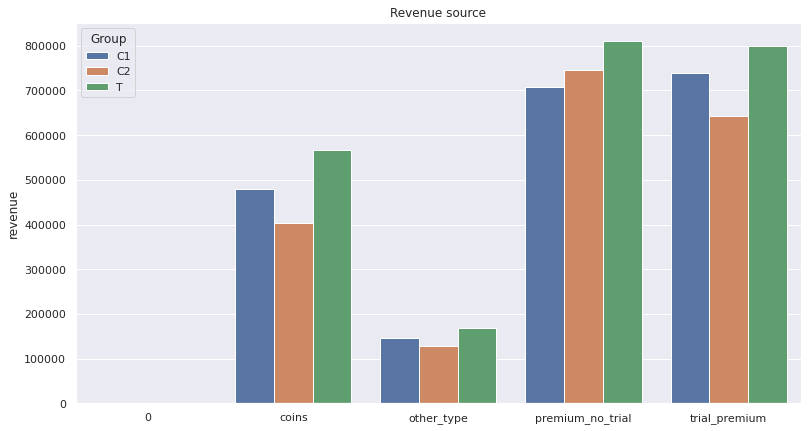

In [49]:
sns.set(rc={'figure.figsize': (13, 7)})
sns.barplot(data = revenue_group1, x = 'product_type', y = 'total', hue = 'Group')
plt.title('Revenue source')
plt.ylabel('revenue')
plt.xlabel('')
plt.legend(title='Group')

По графику можно заметить, что выручка от продажи premium_no_trial увеличилась в тестовой группе.  Предположительно изза увеличения стоимости этого продукта. Проверим это далее.  Увеличение выручки произошло по всем категориям в тестовой группе.

In [50]:
#Поскольку нас интересует продукт премиум, выберем только этот тип продукта
price_premium = revenue_group1.query("product_type == 'premium_no_trial'")
price_premium

,Group,product_type,total
3,C1,premium_no_trial,707044.0
8,C2,premium_no_trial,744809.0
13,T,premium_no_trial,810706.0


In [51]:
# Считаем количество покупок
num_buys = all_together.query("product_type == 'premium_no_trial'").groupby('Group', as_index = False)\
.agg({'revenue':'count'})\
.rename(columns={'revenue': 'num_buys'})

In [52]:

price_premium = price_premium.merge(num_buys, on = 'Group')

In [53]:
# Присоединяем колонку price, разделив выручку по продукту на количество покупок. Имеется ввиду разовая цена,
#которую пользователь заплатил за премиум подписку
price_premium['price'] = price_premium.total/price_premium.num_buys
price_premium

,Group,product_type,total,num_buys,price
0,C1,premium_no_trial,707044.0,103,6864.504854
1,C2,premium_no_trial,744809.0,107,6960.831776
2,T,premium_no_trial,810706.0,76,10667.184211


Из таблицы price_premium теперь можно точно сказать, что в тестовой группе в среднем цены на премиум версию подняли.      Количество покупок снизилось, однако выручка выросла. Посмотрим, можно ли определить в каких странах произошло повышение

In [54]:
premium_country = all_together.query("product_type == 'premium_no_trial'")\
            .groupby(['country','Group'], as_index = False)\
             .agg({'revenue':'sum'})
#создадим датафрейм premium_country, отобрав только строки, с платежами за премиум версию(посколько это 
#был один из  критериев АБ теста) и сгруппируем по странам


In [55]:
num_buy_prem = all_together.query("product_type == 'premium_no_trial'")\
.groupby(['country','Group'], as_index = False)\
.agg({'revenue':'count'})\
.rename(columns={'revenue': 'num_buys'})
premium_country = num_buy_prem.join(premium_country.revenue).fillna(0)

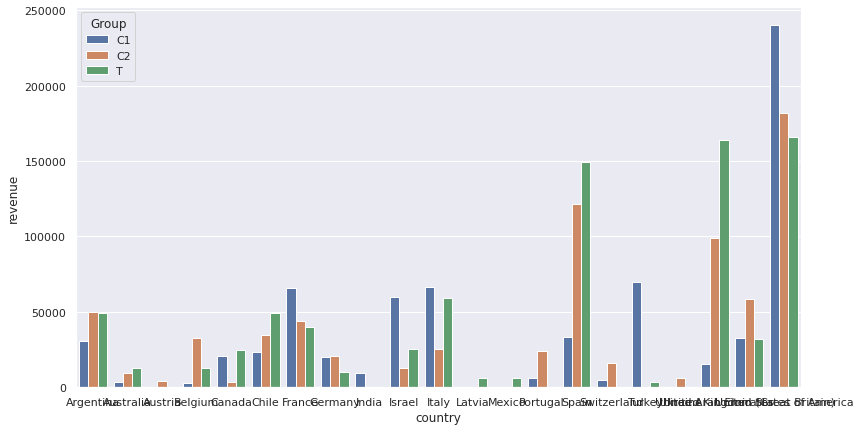

In [56]:

sns.barplot(data=premium_country, x = 'country', y = 'revenue', hue = 'Group')

In [57]:
premium_country['price'] = premium_country.revenue/num_buy_prem.num_buys

premium_country.head()

,country,Group,num_buys,revenue,price
0,Argentina,C1,5,30446.0,6089.200000
1,Argentina,C2,7,50245.0,7177.857143
2,Argentina,T,5,49413.0,9882.600000
3,Australia,C1,1,3588.0,3588.000000
4,Australia,C2,2,9438.0,4719.000000


Из таблицы выше premium_country мы видим в каких странах изменеие цены повлияло на объем покупок и выручку. Выручка по премиум продукту выросла заметно в Испании(за счет увеличения стоимости), Канаде(увеличение числа покупок), и Арабских эмиратах( увеличение стоимости)

In [58]:
pivot_premium_price_countries = pd.pivot_table(premium_country,
               index=[ "country"],
                columns=["Group"],
               values=["price"]
              ).fillna(0)
pivot_premium_price_countries #сопоставление цен по группам и странам

price                            
Group                                     C1            C2             T
country                                                                 
Argentina                        6089.200000   7177.857143   9882.600000
Australia                        3588.000000   4719.000000  12597.000000
Austria                             0.000000   4056.000000      0.000000
Belgium                          3042.000000   6539.000000  12597.000000
Canada                           5209.750000   3549.000000   6119.750000
Chile                            5905.250000   5772.000000   8181.333333
France                           5514.166667   5456.750000   6677.666667
Germany                          5053.750000   6833.666667   5167.500000
India                            4810.000000      0.000000      0.000000
Israel                           5978.700000   6292.000000  12597.000000
Italy                            4768.214286   6405.750000   7400.250000
Latvia                              0.000000      0.000000   6357.000000
Mexico                              0.000000      0.000000   6214.000000
Portugal                         6292.000000   4867.200000      0.000000
Spain                            6669.000000  11066.545455  24918.833333
Switzerland                      4680.000000   5282.333333      0.000000
Turkey                          23361.000000      0.000000   3614.000000
Ukraine                             0.000000   6357.000000      0.000000
United Arab Emirates             5247.666667  24823.500000  23422.285714
United Kingdom (Great Britain)   6500.000000   5326.454545   6466.200000
United States of America         8582.785714   5505.303030   8287.500000

Посчитав стоимость премиум подписки по странам, по тестовой группе можем определить в каких странах было введено увеличение стоимости: **Australia**, **Belgium**, **Israel**, **Spain**, **United Arab Emirates**. Более наглядно отображено в графике ниже. При этом в Арабских Эмиратах стоимость увеличилась уже в группе control_2. К сожалению точно мы не можем определить для каких стран были изменены цены. Есть вероятность того, что пользователь изза новой цены отказался от покупки. Поэтому будем считать усредненно по группе. 



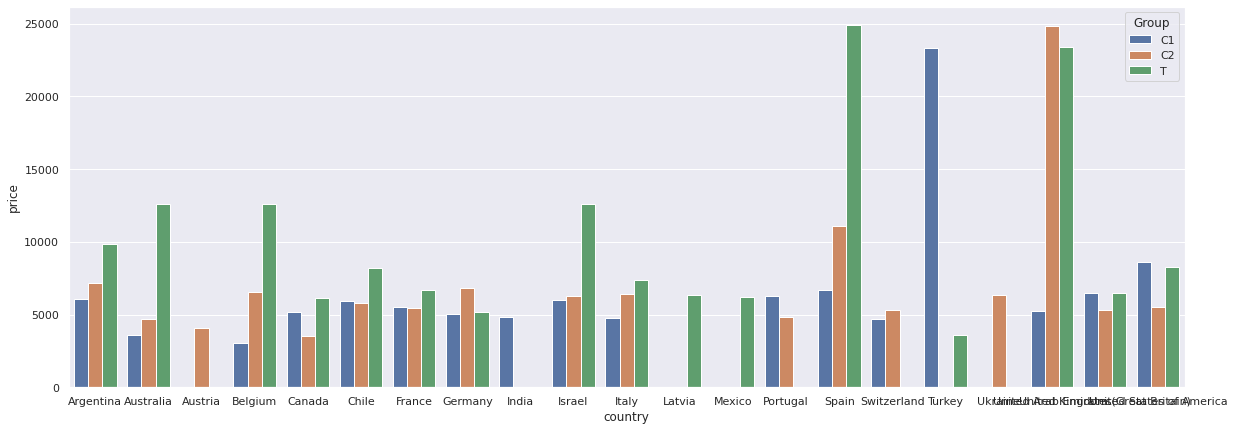

In [59]:
sns.set(rc={'figure.figsize': (20, 7)})
sns.barplot(data=premium_country, x = 'country', y = 'price', hue = 'Group')

**Некоторые страны** не представлены во всех группах среди категории премиум пользователй. (Австрия, Индия, Латвия, Мексика, Украина, Португалия, Швейцария, Турция). Это как раз может быть связано с поднятием цены и отказом от покупки в данных странах. 

**Далее в п.2 я посчитаю однородность групп по критерию распределения пользователей по странам.**

Попытаемся выявить новых пользователей в тестовой группе и посчитать так же изменеие цен в их категории

In [60]:
premium_users= all_together.query("product_type == 'premium_no_trial'")\
            .groupby(['uid','Group'], as_index = False)\
             .agg({'revenue':'sum'})

# отберем обладателей премиум подписки, просуммируем выручку

In [61]:
num_buy_prem_users = all_together.query("product_type == 'premium_no_trial'")\
.groupby(['uid','Group'], as_index = False)\
.agg({'revenue':'count'})\
.rename(columns={'revenue': 'num_buys'})
premium_users = num_buy_prem_users.join(premium_users.revenue).fillna(0)
premium_users
# добавим колонку с количеством покупок

,uid,Group,num_buys,revenue
0,891068079,C2,1,6292.0
1,891071157,T,1,9100.0
2,891077727,C2,1,6292.0
3,891092322,C1,1,5278.0
4,891112263,C2,1,4680.0
...,...,...,...,...
260,892405224,C1,1,6292.0
261,892421277,C1,1,47723.0
262,892426491,T,1,12597.0
263,892434141,T,1,3614.0


In [62]:
premium_users['price'] = premium_users.revenue/num_buy_prem_users.num_buys

premium_users_T = premium_users.loc[((premium_users['Group']== 'T'))]
premium_users_T

,uid,Group,num_buys,revenue,price
1,891071157,T,1,9100.0,9100.0
11,891152790,T,1,12597.0,12597.0
14,891178380,T,1,113477.0,113477.0
19,891222282,T,1,6292.0,6292.0
34,891291531,T,1,4056.0,4056.0
...,...,...,...,...,...
254,892370097,T,1,11115.0,11115.0
257,892390170,T,1,5369.0,5369.0
259,892405179,T,1,9100.0,9100.0
262,892426491,T,1,12597.0,12597.0


In [63]:

premium_users_T.price.describe() #статистика колонки с ценой

count        67.000000
mean      11346.898010
std       18314.900691
min        1898.000000
25%        6285.500000
50%        8164.000000
75%       12103.000000
max      113477.000000
Name: price, dtype: float64

In [64]:
premium_users_T = premium_users.loc[((premium_users['Group']== 'T')&(premium_users['price']>=9500))]
premium_users_T
# отобрала пользователей, которые заплатили цену (я считала среднюю цену учитывая количество покупок)

,uid,Group,num_buys,revenue,price
11,891152790,T,1,12597.0,12597.0
14,891178380,T,1,113477.0,113477.0
51,891346269,T,1,12597.0,12597.0
64,891406224,T,1,12597.0,12597.0
71,891448377,T,1,12597.0,12597.0
79,891499695,T,1,9698.0,9698.0
86,891545874,T,1,12597.0,12597.0
91,891589239,T,1,12597.0,12597.0
94,891605694,T,1,12597.0,12597.0
122,891806436,T,1,12597.0,12597.0


In [65]:
pd.set_option('max_columns', None)

In [66]:
all_together.merge(premium_users_T, how = 'inner' ) # отобрала строки с пользователями, 
#которые как я думаю заплатили более высокую цену

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,joined_at,paid_at,revenue,payment_id,from_page,product_type,Group,num_buys,price
0,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,2017-08-11 00:00:00,2017-10-11 00:00:00,12597.0,147.0,dating,premium_no_trial,T,1,12597.0
1,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,2017-10-31 00:00:00,2017-10-31 00:00:00,12597.0,147.0,popular_users_chat,premium_no_trial,T,1,12597.0
2,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",1,20,35,69,1.0,1.0,12597,2017-10-27 00:00:00,2017-10-30 00:00:00,12597.0,147.0,promo_09,premium_no_trial,T,1,12597.0
3,891882681,36,408,76.0,Belgium,"1,2,3,5,6,7,8,9,10,11,12,14,16,17,18,19,20,21",1,33,39,71,1.0,1.0,20410,2017-10-25 00:00:00,2017-11-11 00:00:00,12597.0,147.0,promo_09,premium_no_trial,T,1,12597.0
4,891406224,25,212,10.0,Israel,"1,2,3,4,5,6,7,8,9,10",1,18,28,80,1.0,1.0,21645,2017-04-11 00:00:00,2017-04-11 00:00:00,12597.0,147.0,autoreply_message,premium_no_trial,T,1,12597.0
5,891499695,42,850,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,19,37,808,1.0,1.0,9698,2017-02-11 00:00:00,2017-11-11 00:00:00,9698.0,147.0,dating,premium_no_trial,T,1,9698.0
6,891346269,34,204,530.0,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647,2017-05-11 00:00:00,2017-05-11 00:00:00,12597.0,147.0,autoreply_message,premium_no_trial,T,1,12597.0
7,891867477,21,173,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,18,24,46,1.0,1.0,12597,2017-10-25 00:00:00,2017-03-11 00:00:00,12597.0,147.0,promo_09,premium_no_trial,T,1,12597.0
8,892186941,44,552,88.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,41,47,38,1.0,1.0,25207,2017-10-19 00:00:00,2017-10-19 00:00:00,12597.0,147.0,dating,premium_no_trial,T,1,12597.0
9,892038759,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565,2017-10-22 00:00:00,2017-10-22 00:00:00,113477.0,147.0,autoreply_message,premium_no_trial,T,1,113477.0


### 1.3. Выводы по первой части
По существующим данным, мы не можем точно определить категорию пользователей, на которую распространились нововведения. Мы выявили, некоторые страны в тестовой группе, где произошло повышение цен: Australia, Belgium, Israel, Spain, United Arab Emirates. **Однако возможно новое предложение действовало и для пользователей из других стран**

Скорее всего, сюда же будут относиться и новые пользователи, и новые платежные системы.  Так как непонятно, где найти информацию о платежной системе, через которую были совершены платежы, не будем на этом останавливаться. По таблице пользователей, которые заплатили относительно высокую цены по сравнению с остальными в группе сложно определить точные критерии выборки. Поэтому будем оценивать всю тестовую группу. 

## 2. Статистика

**До начала анализа АВ-теста, проведем анализ на однородность групп**

  **ПО СТРАНАМ** 

Проведем анализ распределения по странам среди пользователей всех категорий(и платящих и неплатящих). важно чтобы по этому критерию группы были равнозначны, 
так как уровень дохода в разных странах может сильно разниться


In [67]:
#Создадим таблицу распределения по странам и проверим равномерность распределения с помощью Хи квадрат
couuntries_comp = all_together.groupby(['uid', 'Group'], as_index=False) \
    .agg(country=('country', 'first'))
countries_chi = pd.crosstab(couuntries_comp.country, couuntries_comp.Group)
countries_chi

Group,C1,C2,T
country,,,
Algeria,2,0,2
Argentina,389,397,396
Armenia,1,0,0
Australia,50,51,62
Austria,0,2,0
...,...,...,...
United Kingdom (Great Britain),146,146,169
United States of America,1471,1486,1450
Uruguay,0,1,1


In [68]:
#Воспользуемся функцией вычисления chi2_contingency(
g, p, dof, expctd = chi2_contingency(countries_chi)
print(p)

0.6604993611328537


Значение p>0,05, следовательно **распределение по странам между группами является равномерным**

**ПО ВОЗРАСТУ** 

Посмотрим на однородность групп по возрасту


In [69]:
age_comp = all_together.groupby(['uid', 'Group'], as_index=False) \
    .agg(age=('age', 'first'))
age_chi = pd.crosstab(age_comp.age, age_comp.Group) #воспользуемся сводной таблицей для наглядного отображения
age_chi

Group,C1,C2,T
age,,,
16,82,87,82
17,22,9,23
18,74,74,89
19,93,94,74
20,116,115,133
...,...,...,...
90,0,1,0
91,1,0,0
92,0,1,0


In [70]:
# применим тест Левена
import pingouin as pg

In [71]:
pg.homoscedasticity(data=age_comp, dv='age', group='Group')

,W,pval,equal_var
levene,0.382965,0.681845,True


Значение p>0,05, следовательно распределение **по возрасту между группами является равномерным**

**Однородность групп по гендерному признаку(полу)** 

In [72]:
gender_mark = all_together.groupby(['uid', 'Group'], as_index=False) \
    .agg(gender=('gender', 'first'))


In [73]:
pg.homoscedasticity(data=gender_mark, dv='gender', group='Group')

,W,pval,equal_var
levene,0.675158,0.509094,True


По гендерному признаку так же **группы однородны** , так как p value>0.05

Ранее мы сровняли группы по временным рамкам и в сводных таблицах группы выглядят гомогенными. По важным критериям мы посчитали статистически, что группы  равны. 
### 3. проведем АА-тест

Так как контрольных групп у нас две, докажем что эти группы между собой статистически не отличаются по главным метрикам, чтобы потом можно было тестовую группу сравнивать только с одной из контрольных


В качестве метрик возьмем :
- ARPPU выручка от премиум пользователей
- ARPU доля выручки на одного пользователя
- Конверсия

### 3.1. ARPPU - выручка на одного платящего пользователя

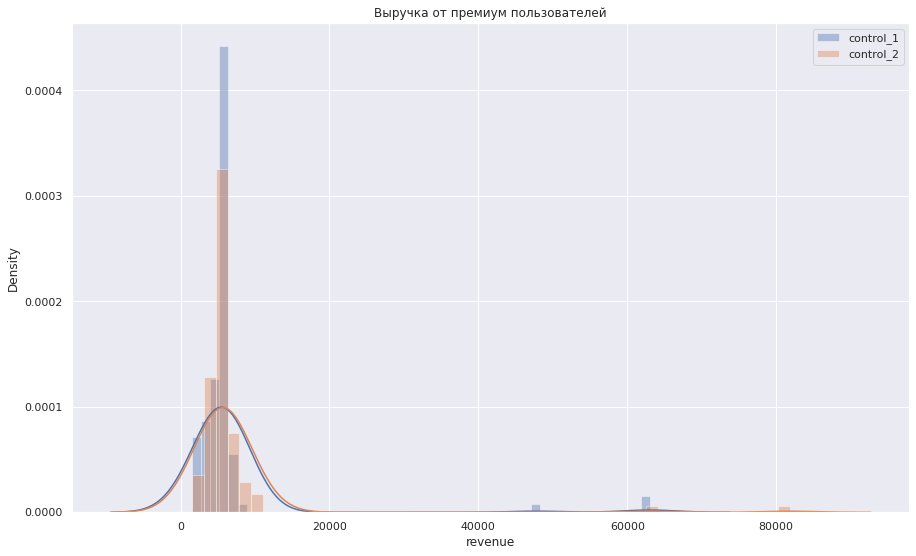

In [74]:
#посмотрим на распределение выручки(revenue)
f, ax = plt.subplots( figsize =(15,9) ) 
sns.distplot( control_1[control_1.product_type == 'premium_no_trial'].revenue, label = 'control_1') 
sns.distplot( control_2[control_2.product_type == 'premium_no_trial'].revenue, label = 'control_2')
plt.title( 'Выручка от премиум пользователей' ) 
plt.legend() 
plt.show() 


In [75]:
C1_prem = control_1[control_1.product_type == 'premium_no_trial'].revenue.reset_index()
C2_prem = control_2[control_2.product_type == 'premium_no_trial'].revenue.reset_index()
#создаем две группы, отобрав только держателей премиум подписки

In [76]:
#Запускаем тест нормальности распределения, чтобы выбрать метод оценки сравнени групп
pg.normality(data=all_together[all_together.product_type == 'premium_no_trial'], dv="revenue", 
                   group="Group", method="normaltest") 

,W,pval,normal
T,123.731270,1.355489e-27,False
C1,150.292290,2.314429e-33,False
C2,183.870165,1.183316e-40,False


На графиках большие выбросы, по результам теста распределение не нормальное.

In [77]:
#использую  метод bootstrap на средних. 

In [78]:
#используем готовую функци bootstrap
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu, shapiro


from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu, shapiro

def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value} #"boot_data": boot_data,

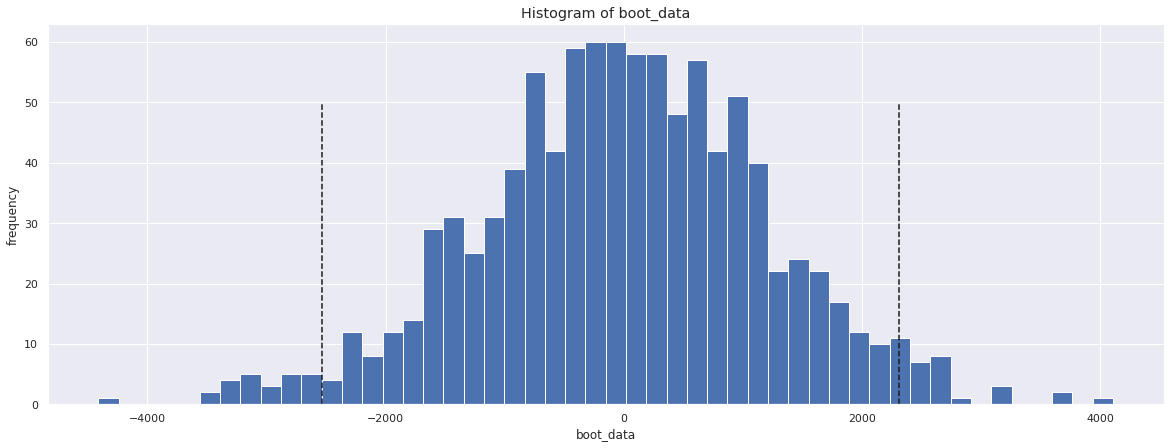

In [79]:
ARPPU_rev= get_bootstrap_mean(C1_prem.revenue,
                             C2_prem.revenue)

In [80]:
ARPPU_rev

{'ci':                  0
 0.025 -2533.444860
 0.975  2313.173832,
 'p_value': 0.9922776895451583}

Посмотрим доверительный интервал с уровнем значимости 0.95;
Поскольку 0 принадлежит ДИ, то отличия статистически не значимы на уровне значимости

### 3.2. ARPU - выручка на одного пользователя

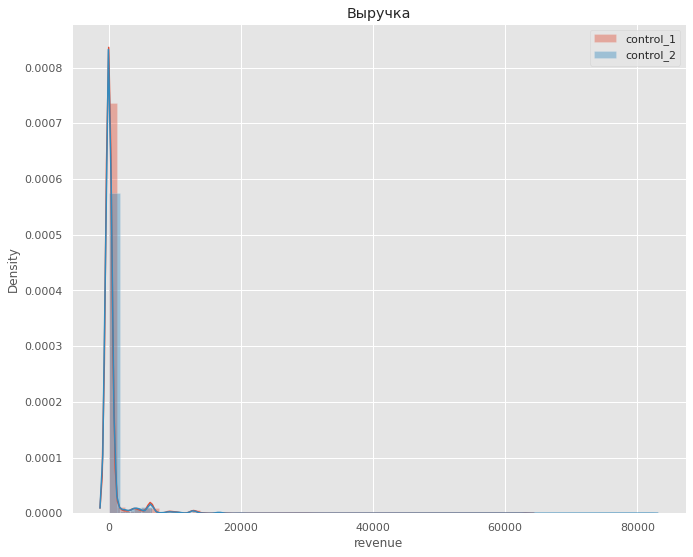

In [81]:
f, ax = plt.subplots( figsize =(11,9) ) 
sns.distplot( control_1.revenue, label = 'control_1') 
sns.distplot( control_2.revenue, label = 'control_2')
plt.title( 'Выручка' ) 
plt.legend() 
plt.show() 

Поскольку большинство пользователей не платят за пользование сервисом, здесь видно явное смещение к нулю

Плотность около нуля и есть хвосты. Так же воспользуемся bootstrap методом

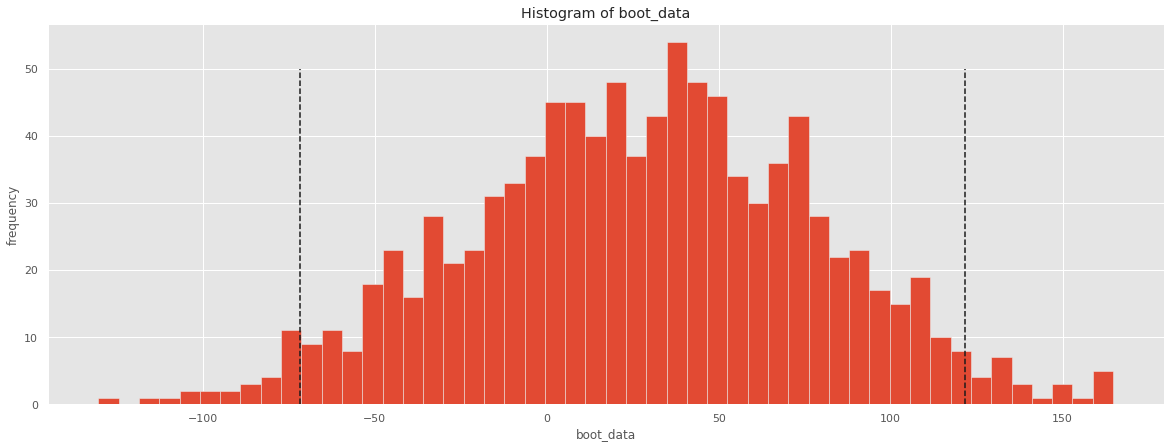

In [83]:
ARPU_rev = get_bootstrap_mean(all_together.query('Group=="C1"').revenue,
                                     all_together.query('Group=="C2"').revenue)

In [84]:
ARPU_rev

{'ci':                 0
 0.025  -71.673647
 0.975  121.493396,
 'p_value': 0.587645880762313}

По средней выручке на каждого пользователя группы так же похожи

### 3.3 Посчитаем на схожесть уровня конверсии в двух контрольных группах
Воспользуемся в этому случае методом Хи квадрат

In [85]:
#Нам нужно посчитать количество всех уникальных пользователей и количество обладателей премиум подписки.
all_users_count = all_together.query('Group!="T"').groupby('Group', as_index = False).agg({'uid':'count'}) # Подсичтываем количество 
                                              # уникальных пользователей в двух группах
conversion_yes_group = all_together[all_together.Group != 'T'].query("product_type == 'premium_no_trial'").groupby('Group', as_index = False).agg({'uid':'count'})
conversion_yes_group = all_users_count.merge(conversion_yes_group, on = 'Group')
conversion_yes_group['perc'] = conversion_yes_group.uid_y/conversion_yes_group.uid_x*100 
#создали таблицу с колонкой конверсии в процентах

In [86]:
conversion_yes_group

,Group,uid_x,uid_y,perc
0,C1,4490,103,2.293987
1,C2,4405,107,2.429058


In [87]:
#для создания свобной таблицы промаркируем
conversion_yes = all_together[all_together.Group != 'T'].query("product_type == 'premium_no_trial'")
conversion_no = all_together[all_together.Group != 'T'].query("product_type != 'premium_no_trial'")

In [88]:
conversion_yes['convert']= '1'
conversion_no['convert'] = '0'
#Созжаем маркировку пользователей по конверсии

In [89]:
conv = pd.concat([conversion_yes, conversion_no])

In [90]:
a = pd.crosstab(conv.Group, conv.convert) #таблица сопряженности
a
#Мы видим увеличение конверсии в платного пользователя в контрольных группах.Воспользуемся функцией Хи квадрат
# 0 - не свонвертированные, 1 - сконвертированные

convert,0,1
Group,,
C1,4387,103
C2,4298,107


In [91]:
g, p, dof, expctd = chi2_contingency(a)
print('р уровень значимости равен:', p)

р уровень значимости равен: 0.726589163691989


следовательно статистически  по уровню конверсии группы значимо не различаются

### 4. АВ тесты и проверка гипотезы
Проверим те же метрики:
 - ARPU
 - ARPPU
 - конверсия

Так как мы доказали, что контрольные группы статистически значимо не различаются, можем группы соединить в одну(Так как проверяем величины относительные, в статистических тестах мы сравниваем средние, поэтому разноразмерность выборок на результат не повлияет. Конкретно при бутстрапе допускается брать выборки разного размера, так как он создает синтетические выборки, тем самым выравнивает их размеры)

In [101]:
Control_group = all_together[all_together.Group !='T']#оставим только контрольную группу
Control_group['Group'] = 'C'# промаркируем колонку Group символом 'C'

In [102]:
Control_group.shape # определим размер объединенной группы

(8895, 20)

In [103]:
test_AB_group = all_together[all_together.Group == 'T'] #тестовая группа

### 4.1 ARPPU

Посколько распределение показало большую плотность в нуле, для нас важнее метрика доход на платящего пользователя

In [104]:
#Соберем таблицу по доходу
ARPPU_control = Control_group.query("product_type == 'premium_no_trial'")\
                        .groupby('uid', as_index = False).agg({'revenue': 'sum'})
ARPPU_test =  test_AB_group.query("product_type == 'premium_no_trial'")\
                        .groupby('uid', as_index = False).agg({'revenue': 'sum'})
ARPPU = pd.concat([Control_group, test_AB_group]).query("product_type == 'premium_no_trial'")
ARPPU_table = ARPPU.groupby('Group', as_index = False).agg({'revenue': 'sum'})
ARPPU_table

,Group,revenue
0,C,1451853.0
1,T,810706.0


In [105]:
users_count = ARPPU.groupby(['Group'], as_index = False).agg({'uid' :'count'}) #подсчитаем количество уникальных
                            #пользователей
users_count

,Group,uid
0,C,210
1,T,76


In [106]:
ARPPU_table = ARPPU_table.merge(users_count)
ARPPU_table['ARPPU'] = ARPPU_table.revenue/ ARPPU_table.uid #добавим все в одну таблицу

In [107]:
ARPPU_table

,Group,revenue,uid,ARPPU
0,C,1451853.0,210,6913.585714
1,T,810706.0,76,10667.184211


ARPPU выше в тестовой группе

In [109]:
from scipy import stats

stats.ttest_ind(ARPPU_control.revenue, ARPPU_test.revenue)

Ttest_indResult(statistic=-2.7381171029018034, pvalue=0.006601171797063991)

На первый взгляд, доход на одного платящего пользователя увеличился в тестовой группе. Посмотрим по графику и проведем анализ этой метрики

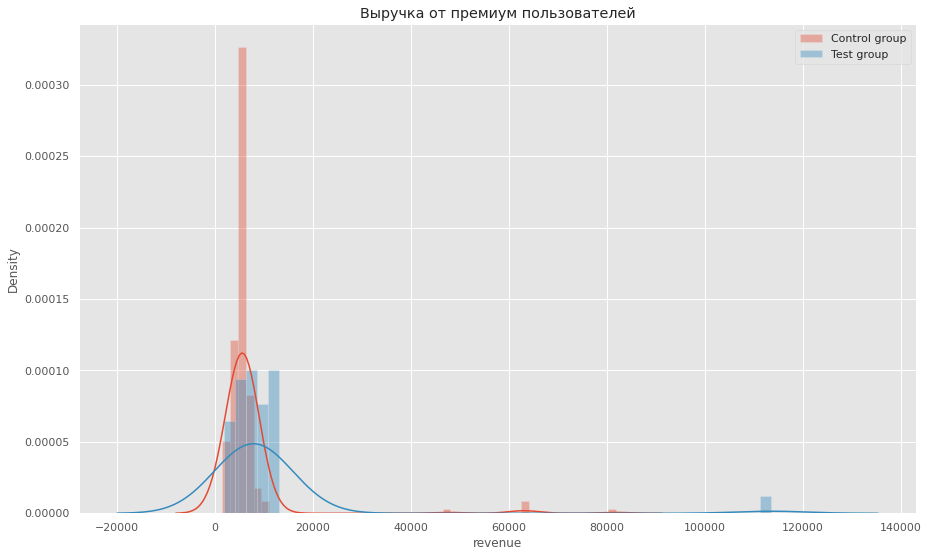

In [110]:
f, ax = plt.subplots( figsize =(15,9) ) 
sns.distplot( Control_group[Control_group.product_type == 'premium_no_trial'].revenue, label = 'Control group') 
sns.distplot( test_AB_group[test_group.product_type == 'premium_no_trial'].revenue, label = 'Test group')
plt.title( 'Выручка от премиум пользователей' ) 
plt.legend() 
plt.show()

Судя по графику мы можем скачать, что распределение в тестовой группе имеет более плавную форму, значит увеличился разброс ценовых категорий. Хвосты однако у обоих групп вправо очень большие,
воспользуемся методом бутстрапа.

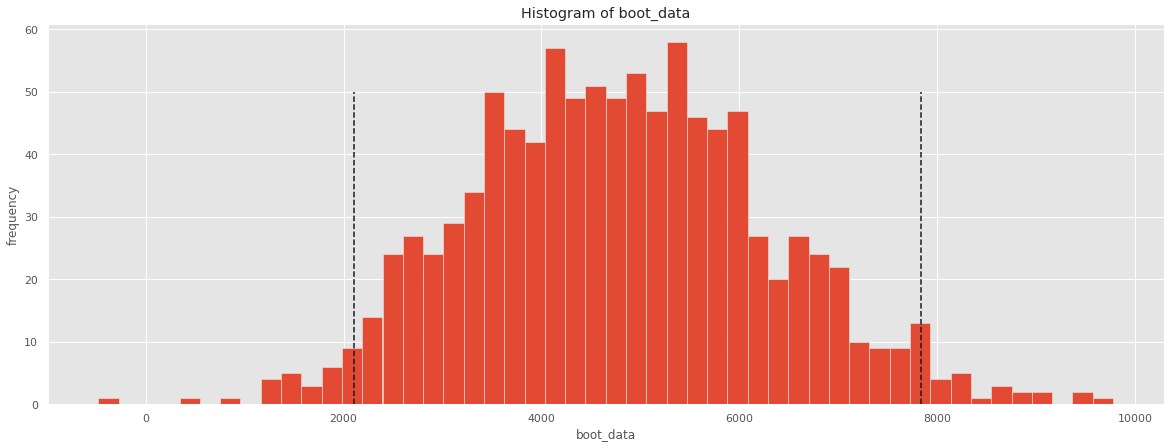

In [111]:
ARPPU_AB_boot = get_bootstrap_mean(ARPPU_test.revenue, ARPPU_control.revenue)

In [112]:
ARPPU_AB_boot

{'ci':                  0
 0.025  2101.466414
 0.975  7839.231439,
 'p_value': 0.0014463573764303482}

в доверительных интервалах ноль не перекрывается, p значение меньше 0,05. Можно говорить о надежности результата. 

### 4.2 ARPU метрика
В нашем случае данная метрика менее показательна, чем предыдущая. Показывает объем выручке в расчете на общее количество пользователей

In [113]:
#для наглядности создадим сводную таблицу
ARPU_control =Control_group\
                    .groupby('uid', as_index = False).agg({'revenue': 'sum'})
ARPU_test =  test_AB_group\
                    .groupby('uid', as_index = False).agg({'revenue': 'sum'})
ARPU = pd.concat([Control_group, test_AB_group])\
                    .query("product_type != 'premium_no_trial'")
ARPU_table = ARPU.groupby('Group', as_index = False)\
                    .agg({'revenue': 'sum'})
users_count_arpu = pd.concat([Control_group, test_AB_group])\
                    .groupby(['Group'], as_index = False).agg({'uid' :'count'})

In [114]:
ARPU_table = ARPU_table.merge(users_count_arpu)
ARPU_table['ARPU'] = ARPU_table.revenue/ ARPU_table.uid
ARPU_table

,Group,revenue,uid,ARPU
0,C,2540083.0,8895,285.563013
1,T,1534195.0,4435,345.928974


ARPU в тестовой группе больше, чем в контрольной. Проверим, можем ли мы положиться на этот результат

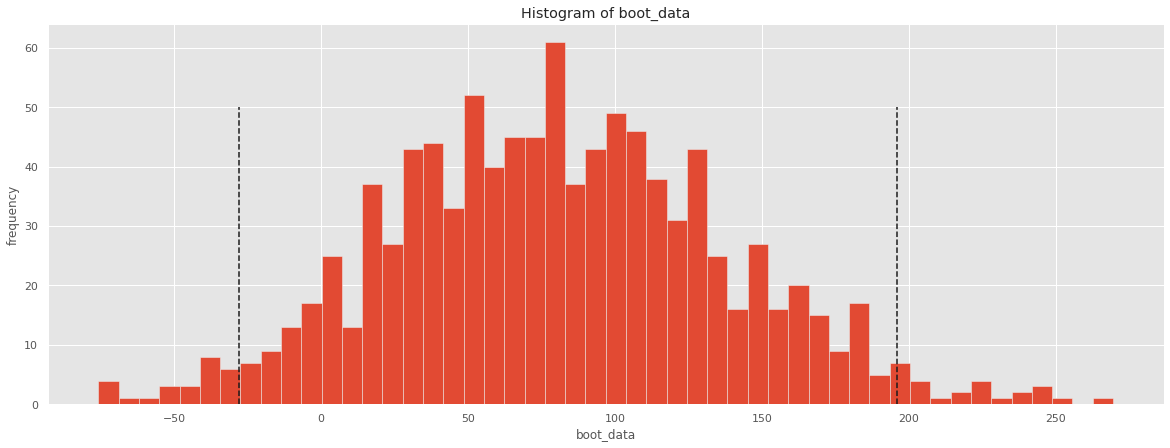

In [115]:
ARPU_AB_boot = get_bootstrap_mean( ARPU_test.revenue, ARPU_control.revenue)

In [117]:
ARPU_AB_boot

{'ci':                 0
 0.025  -28.050488
 0.975  195.926645,
 'p_value': 0.15690791098902984}

Данная метрика хоть и оказалась немного выше у тестовой группы, однако перекрывается ноль и p value находится на граничном значении 0.05. Так что разницу здесь можно во мнимание не принимать

### 4.3 считаем конверсию в премиум версию в двух группах

In [118]:
conversion_yes_AB = pd.concat([Control_group, test_AB_group]).query("product_type == 'premium_no_trial'")
conversion_no_AB = pd.concat([Control_group, test_AB_group]).query("product_type != 'premium_no_trial'")
#схема такая же как в конверсии в AA тесте

In [119]:
conversion_yes_AB['convert']= '1' #создаем столбец с маркировкой по конверсии
conversion_no_AB['convert'] = '0'

In [120]:
conv_AB = pd.concat([conversion_yes_AB, conversion_no_AB])
all_users_count_AB = pd.concat([Control_group, test_AB_group]).groupby('Group', as_index = False).agg({'uid':'count'}) # Подсичтываем количество 
                                              # уникальных пользователей в двух группах
all_users_count_AB

,Group,uid
0,C,8895
1,T,4435


In [121]:
conversion_yes_group_AB = pd.concat([Control_group, test_AB_group])\
            .query("product_type == 'premium_no_trial'")\
            .groupby('Group', as_index = False).agg({'uid':'count'})
conversion_yes_group_AB

,Group,uid
0,C,210
1,T,76


In [122]:
conversion_yes_group_AB = all_users_count_AB.merge(conversion_yes_group_AB, on = 'Group')
conversion_yes_group_AB['perc'] = conversion_yes_group_AB.uid_y/conversion_yes_group_AB.uid_x*100 
conversion_yes_group_AB

,Group,uid_x,uid_y,perc
0,C,8895,210,2.360877
1,T,4435,76,1.713641


Снижение уровня конверсии в тестовой группе

In [125]:
AB = pd.crosstab(conv_AB.Group, conv_AB.convert) #таблица сопряженности
AB

convert,0,1
Group,,
C,8685,210
T,4359,76


In [126]:
g, p, dof, expctd = chi2_contingency(AB)
print('р уровень значимости равен:', p) # тест хи квадрат

р уровень значимости равен: 0.017953202059527856


Результат теста значимости разницы конверсии p value < 0,05 нам НЕ дает основания пренебречь разницей в результатах,   конверсия в тестовой группе снизилась по сравнению с контрольной

## 5. Выводы

Мы посчитали статистическую значимость трех метрик по результатам AB тестирования введения ценовых изменений. Период проведения тестирования 1 год. Таким образом сезонность не будет влиять на общие результаты. 
    Самой важной метрикой для бизнеса является доходность и доход. В нашем случае мы посчитали ARPPU. Тестовая группа показала лучшие результаты и это подтвердилось анализом статзначимости разницы. 
Что касается конверсии, то здесь наблюдается снижение результата у **тестовой группы (1,7%)** по сравнению с **контрольной (2.4%)** .  

По ARPU тестовая группа показала немного лучше результаты, чем контрольная, однако стат тест определил что такое превышение может быть случайным. И не будем его брать во внимание. 

Далее мы посчитали поступление платежей по дате. В тестовой группе здесь также наблюдается рост по сравнению с контрольной. 
Я предлагаю принять нововведения, так как по главным метрикам для бизнеса тест показал стат значимые результаты. Увеличилась выручка от премиум подписки, средний чек. к сожалению пострадала конверсия, но этого следует ожидать при увеличении цен на продукт

In [197]:
price_premium # таблица сравнения показателей по премиум продукту

,Group,product_type,total,num_buys,price
0,C1,premium_no_trial,707044.0,103,6864.504854
1,C2,premium_no_trial,744809.0,107,6960.831776
2,T,premium_no_trial,810706.0,76,10667.184211
